In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pylab
from os import scandir
import contextlib
import random
import wave
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Dropout

from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.
C:\Users\pc\Anaconda3\envs\Keras\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\pc\Anaconda3\envs\Keras\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\pc\Anaconda3\envs\Keras\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\pc\Anaconda3\envs\Keras\lib\site-packages\tenso

### Create all the matrix spectrograms

In [4]:
def ls(path): 
    return [obj.name for obj in scandir(path) if obj.is_file()]

In [5]:
# Return the index of the columns that corresponds to the value in the beat 
# Beat in miliseconds
def getColumnIndexFromTime(beat, ColumnDuration):
    return int(beat/ColumnDuration)

In [6]:
goodSongs = ["313", "324", "339", "346", "347", "350", "362", "380", "382", "391", "394", "398", "404", "406", "410", "418"
             , "438", "442", "445", "453", "467", "470", "479", "449", "506", "511", "519", "526", "528", "539", "558", 
             "585", "599", "603", "613", "629", "632", "634", "637", "639", "671", "674", "699", "708", "716", "719", "721"]

In [7]:
len(goodSongs)

47

In [8]:
path = '../../../PD/cancionesytags'
songs = ls(path)
msg = ""
specs_dir = {}
#Frame rate
sr = 48000
#print("File - mels - #Columns - ColumnDuration - SongDuration")

colsDuration = {}
for song in songs:
    data = song.split(".")
    if data[1] == "wav" and (data[0] in goodSongs):
        file_path = path+"/"+song
        
        # Get the duration of a song
        with contextlib.closing(wave.open(file_path,'r')) as f:
            frames = f.getnframes()
            duration = frames / float(sr)
            
        y, sr = librosa.load(file_path, sr=48000, duration=duration)
        whale_song, _ = librosa.effects.trim(y)

        n_mels = 40
        hop_length = 512
        n_fft = 2048

        S = librosa.feature.melspectrogram(whale_song, sr=sr, n_fft=n_fft, 
                                           hop_length=hop_length, 
                                           n_mels=n_mels)
        S_DB = librosa.power_to_db(S, ref=np.max)
        
        specs_dir[data[0]] = S_DB
        np.savetxt("Data/Spectrograms/Matrix/"+data[0]+".csv", S_DB, delimiter=",")

        oneSecLength = len(S_DB[0])/duration
        colsDuration[data[0]] = (1/oneSecLength)
        print(data[0] + " - " + str(len(S_DB)) + " - " + str(len(S_DB[0])) + "  -  " + str(round((1/oneSecLength)*1000, 4))+ " ms  -  "+str(duration ))

313 - 40 - 23127  -  10.6847 ms  -  247.10497916666668
324 - 40 - 26612  -  10.8024 ms  -  287.4729791666667
339 - 40 - 27048  -  10.8767 ms  -  294.19297916666665
346 - 40 - 26862  -  10.8439 ms  -  291.28897916666665
347 - 40 - 14033  -  10.8704 ms  -  152.54497916666668
350 - 40 - 16813  -  10.8374 ms  -  182.20897916666667
362 - 40 - 15016  -  10.7582 ms  -  161.54497916666668
380 - 40 - 15788  -  10.9056 ms  -  172.17697916666665
382 - 40 - 22618  -  10.8063 ms  -  244.41697916666666
391 - 40 - 32461  -  10.7686 ms  -  349.56097916666664
394 - 40 - 15804  -  11.0039 ms  -  173.90497916666666
398 - 40 - 31846  -  10.8455 ms  -  345.38497916666665
404 - 40 - 25757  -  10.7827 ms  -  277.72897916666665
406 - 40 - 20636  -  10.8452 ms  -  223.80097916666668
410 - 40 - 26199  -  10.7931 ms  -  282.76897916666667
418 - 40 - 26767  -  10.7909 ms  -  288.84097916666667
438 - 40 - 38228  -  10.6779 ms  -  408.19297916666665
442 - 40 - 16345  -  10.8746 ms  -  177.74497916666667
445 - 40 - 

In [9]:
def getListBeats(song, columns, beats):
    beatsList = [0] * columns
    badBeats = 0
    for beat in range(len(beats)):
        col = getColumnIndexFromTime(beat, colsDuration[song])
        if col > columns:
            badBeats+=1
        else:
            beatsList[col-5] = 1
            beatsList[col-4] = 1
            beatsList[col-3] = 1
            beatsList[col-2] = 1
            beatsList[col-1] = 1
            beatsList[col] = 1
            if col+1 < columns:
                beatsList[col+1] = 1
                if col+2 < columns:
                    beatsList[col+2] = 1
                    if col+3 < columns:
                        beatsList[col+3] = 1
                        if col+4 < columns:
                            beatsList[col+4] = 1
                            if col+5 < columns:
                                beatsList[col+5] = 1

    
    print(song+" - Bad beats: "+str(badBeats))
    return beatsList

In [10]:
def loadAllBeats():
    path = 'Data/Processed_Songs'
    songs = ls(path)
    beatsList = {}
    
    for song in songs:
        totalPath = path +"/"+song
        
        f = open(totalPath, "r")
        beats = []
        while(True):
            line = f.readline()
            if not line:
                break
            data = line.split(",")
            beat = int(data[0])/1000
            beats.append(beat)
        
        aux = song.split(".")
        beatsList[aux[0]] = beats
        f.close()
        
    return beatsList

In [11]:
df =  pd.DataFrame()
beats = loadAllBeats()
for song in specs_dir:
    matrix = specs_dir[song]
    matrix = matrix.transpose()
    aux = pd.DataFrame(matrix)
    col = [x for x in range(len(matrix))]
    aux['Song'] = song 
    aux['ColumnOrder'] = col
    aux["isBeat"] = getListBeats(song, len(matrix), beats[song])
    names = ['Song','ColumnOrder', 'isBeat']
    index = [x for x in range(40)]
    names += index
    aux = aux[names]
    aux[['isBeat']] = aux[['isBeat']].astype(str)
    df = pd.concat([df, aux])

313 - Bad beats: 0
324 - Bad beats: 110
339 - Bad beats: 307
346 - Bad beats: 309
347 - Bad beats: 100
350 - Bad beats: 84
362 - Bad beats: 65
380 - Bad beats: 23
382 - Bad beats: 174
391 - Bad beats: 131
394 - Bad beats: 63
398 - Bad beats: 126
404 - Bad beats: 65
406 - Bad beats: 84
410 - Bad beats: 107
418 - Bad beats: 107
438 - Bad beats: 235
442 - Bad beats: 114
445 - Bad beats: 9
453 - Bad beats: 108
467 - Bad beats: 79
470 - Bad beats: 112
479 - Bad beats: 28
506 - Bad beats: 182
511 - Bad beats: 82
519 - Bad beats: 153
526 - Bad beats: 216
528 - Bad beats: 97
539 - Bad beats: 140
558 - Bad beats: 180
585 - Bad beats: 135
599 - Bad beats: 107
603 - Bad beats: 206
613 - Bad beats: 108
629 - Bad beats: 139
632 - Bad beats: 137
634 - Bad beats: 69
637 - Bad beats: 117
639 - Bad beats: 46
671 - Bad beats: 115
674 - Bad beats: 45
699 - Bad beats: 117
708 - Bad beats: 96
716 - Bad beats: 151
719 - Bad beats: 95
721 - Bad beats: 136


In [12]:
df.head()

,Song,ColumnOrder,isBeat,0,1,2,3,4,5,6,...,30,31,32,33,34,35,36,37,38,39
0,313,0,1,-63.103856,-70.212227,-73.862468,-76.654792,-78.722161,-80.000000,-78.621511,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
1,313,1,1,-51.887011,-64.589839,-68.668699,-73.664318,-76.343428,-75.643455,-76.791360,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
2,313,2,1,-36.701945,-51.484077,-59.188797,-63.324137,-68.088914,-66.341680,-73.554816,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
3,313,3,1,-31.235697,-49.075736,-56.182441,-61.215856,-65.799084,-65.156269,-72.138986,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
4,313,4,1,-33.361112,-54.452346,-62.712576,-67.620056,-71.704342,-72.788750,-76.446006,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0


## Plots

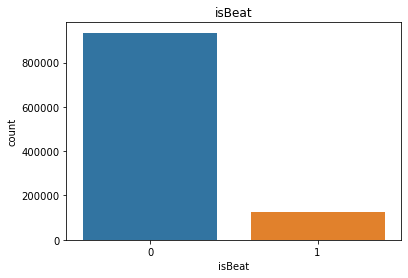

In [13]:
fig, ax = plt.subplots()
sns.countplot(x="isBeat", data=df)
plt.title("isBeat")
plt.show()

In [14]:
df[df.isBeat == "1"]

,Song,ColumnOrder,isBeat,0,1,2,3,4,5,6,...,30,31,32,33,34,35,36,37,38,39
0,313,0,1,-63.103856,-70.212227,-73.862468,-76.654792,-78.722161,-80.000000,-78.621511,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
1,313,1,1,-51.887011,-64.589839,-68.668699,-73.664318,-76.343428,-75.643455,-76.791360,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
2,313,2,1,-36.701945,-51.484077,-59.188797,-63.324137,-68.088914,-66.341680,-73.554816,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
3,313,3,1,-31.235697,-49.075736,-56.182441,-61.215856,-65.799084,-65.156269,-72.138986,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
4,313,4,1,-33.361112,-54.452346,-62.712576,-67.620056,-71.704342,-72.788750,-76.446006,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23349,721,23349,1,-61.742350,-65.515137,-66.841996,-69.295191,-65.227459,-65.355822,-69.455985,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
23350,721,23350,1,-57.272715,-64.743665,-69.019730,-69.218095,-62.973820,-65.661120,-69.357085,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
23351,721,23351,1,-55.999674,-66.983575,-71.338820,-70.994883,-68.036579,-71.336260,-74.283804,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0
23352,721,23352,1,-63.829093,-79.133493,-79.082769,-80.000000,-80.000000,-80.000000,-80.000000,...,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0,-80.0


In [15]:
df[df.isBeat == "0"]

,Song,ColumnOrder,isBeat,0,1,2,3,4,5,6,...,30,31,32,33,34,35,36,37,38,39
6,313,6,0,-42.305813,-53.101814,-60.944559,-71.966493,-75.552743,-75.153221,-75.893178,...,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.0,-80.0,-80.0,-80.0
7,313,7,0,-42.146488,-54.517934,-59.471589,-65.037719,-70.429911,-75.103609,-73.619408,...,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.0,-80.0,-80.0,-80.0
8,313,8,0,-40.108776,-46.396143,-51.612930,-54.779606,-58.629795,-61.926637,-59.832531,...,-79.905334,-79.793268,-77.908583,-77.539063,-78.458668,-79.076607,-80.0,-80.0,-80.0,-80.0
9,313,9,0,-36.062029,-30.742244,-32.881006,-34.023873,-36.693230,-38.142821,-36.766888,...,-79.249970,-78.747309,-78.630831,-77.194200,-77.482389,-77.111445,-80.0,-80.0,-80.0,-80.0
10,313,10,0,-28.282839,-20.827545,-24.340019,-22.700071,-27.784680,-33.307797,-30.576908,...,-77.449837,-78.556083,-78.565925,-78.820889,-79.039828,-77.998246,-80.0,-80.0,-80.0,-80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23344,721,23344,0,-59.160957,-57.577750,-66.004413,-64.653357,-59.537837,-64.829174,-66.435328,...,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.0,-80.0,-80.0,-80.0
23345,721,23345,0,-60.583658,-60.469853,-67.013223,-64.015167,-59.452268,-64.476292,-67.086378,...,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.0,-80.0,-80.0,-80.0
23346,721,23346,0,-62.542127,-60.925539,-65.315771,-65.932357,-60.912420,-62.591208,-71.095728,...,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.0,-80.0,-80.0,-80.0
23347,721,23347,0,-57.671399,-57.549434,-62.189788,-65.634450,-61.737269,-63.631093,-71.490100,...,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.000000,-80.0,-80.0,-80.0,-80.0


In [16]:
(906816/(122018 + 906816)) * 100

88.14016644084468

In [17]:
# Save dataframe 


df.to_csv(path_or_buf="Data/Spectrograms/FinalDF/clear_data.csv")

## Split the data

In [18]:
x = df.iloc[:, 3:] 
y = df.iloc[:, 2]

In [19]:
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=12345, stratify=y)
splitPoint = int(df.shape[0]*0.75)
X_train = x.iloc[:splitPoint]
X_test = x.iloc[splitPoint:]
y_train = y.iloc[:splitPoint]
y_test = y.iloc[splitPoint:]

#X_test, y_test = np.array(X_test), np.array(y_test)


In [20]:
pd.DataFrame(y_train)

,isBeat
0,1
1,1
2,1
3,1
4,1
...,...
6468,0
6469,0
6470,0
6471,0


In [21]:
x_scaler = MinMaxScaler()
X_train = x_scaler.fit_transform(X_train)

In [22]:
x_scaler = MinMaxScaler()
X_test = x_scaler.fit_transform(X_test)

## Create the LSTM model

In [22]:
# create the model
embedding_vecor_length = 40
top_words = 5000
max_cols_length = 40


In [23]:
modelLSTM = Sequential()
modelLSTM.add(Embedding(top_words, embedding_vecor_length, input_length=max_cols_length))
modelLSTM.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
modelLSTM.add(Dense(1, activation='sigmoid'))
modelLSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelLSTM.summary())
history = modelLSTM.fit(X_train, y_train, epochs=30, batch_size=100)
modelLSTM.save('lstm_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 40)            200000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
795280/795280 [==============================] - 378s 475us/step - loss: 0.3645 - accuracy: 0.8816
Epoch 2/30
795280/795280 [==============================] - 371s 467us/step - loss: 0.3640 - accuracy: 0.8816
Epoch 3/30
795280/795280 [=======

In [24]:
# Final evaluation of the model
scores = modelLSTM.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 88.07%


In [1]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined

## LSTM and CNN model


In [ ]:
modelLSTM-CNN = Sequential()
modelLSTM-CNN.add(Embedding(top_words, embedding_vecor_length, input_length=max_cols_length))
modelLSTM-CNN.add(Conv1D(filters=40, kernel_size=40, padding='same', activation='relu'))
modelLSTM-CNN.add(MaxPooling1D(pool_size=2))
modelLSTM-CNN.add(LSTM(100))
modelLSTM-CNN.add(Dense(1, activation='sigmoid'))
modelLSTM-CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelLSTM-CNN.summary())
history = modelLSTM-CNN.fit(X_train, y_train, epochs=30, batch_size=100)
modelLSTM-CNN.save('lstm_cnn_model.h5')
# Final evaluation of the model
scores = modelLSTM-CNN.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## LSTM Model from https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.3-advanced-usage-of-recurrent-neural-networks.ipynb

In [28]:

model2 = Sequential()
model2.add(Embedding(1000, 40))
model2.add(LSTM(32))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model2.fit(X_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2)
model2.save('lstm_2_model.h5')

Train on 636224 samples, validate on 159056 samples
Epoch 1/30
636224/636224 [==============================] - 108s 170us/step - loss: 0.3644 - acc: 0.8815 - val_loss: 0.3641 - val_acc: 0.8815
Epoch 2/30
636224/636224 [==============================] - 105s 166us/step - loss: 0.3639 - acc: 0.8816 - val_loss: 0.3653 - val_acc: 0.8815
Epoch 3/30
636224/636224 [==============================] - 103s 161us/step - loss: 0.3639 - acc: 0.8816 - val_loss: 0.3668 - val_acc: 0.8815
Epoch 4/30
636224/636224 [==============================] - 103s 161us/step - loss: 0.3639 - acc: 0.8816 - val_loss: 0.3641 - val_acc: 0.8815
Epoch 5/30
636224/636224 [==============================] - 104s 163us/step - loss: 0.3638 - acc: 0.8816 - val_loss: 0.3640 - val_acc: 0.8815
Epoch 6/30
636224/636224 [==============================] - 106s 166us/step - loss: 0.3638 - acc: 0.8816 - val_loss: 0.3642 - val_acc: 0.8815
Epoch 7/30
636224/636224 [==============================] - 106s 166us/step - loss: 0.3638 - acc

In [29]:
scores = model2.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 88.07%


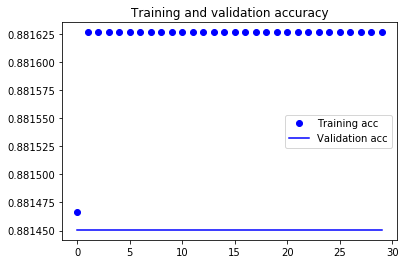

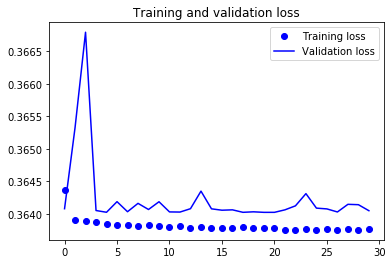

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()